In [43]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv('../data/energy-charts_Electricity_production_and_spot_prices_in_Germany_in_2014.csv', skiprows=2)
df = df[['Unnamed: 0', 'Price (EUR/MWh, EUR/tCO2)']]
for i in range (1, 6):
    tmp_df = pd.read_csv(f'../data/energy-charts_Electricity_production_and_spot_prices_in_Germany_in_{2014+i}.csv', skiprows=2)
    tmp_df = tmp_df[['Unnamed: 0', 'Price (EUR/MWh, EUR/tCO2)']]
    df = pd.concat([df, tmp_df], ignore_index=True)
df.columns = ['Timestamp', 'Price']
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True).dt.tz_convert('Europe/Berlin')
df = df.set_index('Timestamp')

In [45]:
window = 24*3
df['Moving Average'] = df['Price'].rolling(window=window).mean()
df['Moving Std'] = df['Price'].rolling(window=window).std()
df['Moving Momentum'] = df['Price'].rolling(window=window).apply(lambda x: np.mean(np.diff(x)))
df.dropna(inplace=True)
df

,Price,Moving Average,Moving Std,Moving Momentum
Timestamp,,,,
2014-01-03 23:00:00+01:00,11.67,24.337083,12.550731,-0.049014
2014-01-04 00:00:00+01:00,10.07,24.266528,12.617207,-0.040704
2014-01-04 01:00:00+01:00,9.84,24.223194,12.661865,-0.031690
2014-01-04 02:00:00+01:00,7.93,24.165417,12.727332,-0.053099
2014-01-04 03:00:00+01:00,5.23,24.075556,12.838935,-0.090563
...,...,...,...,...
2019-12-31 19:00:00+01:00,46.00,29.235556,10.000640,0.089859
2019-12-31 20:00:00+01:00,42.20,29.271389,10.042906,0.095915
2019-12-31 21:00:00+01:00,39.74,29.331806,10.093191,0.070282


In [46]:
X = df[['Moving Std', 'Moving Momentum']].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
model.fit(X)

df["Regime"] = model.predict(X)
df['Regime'] = df['Regime'].shift(-window // 2)
df['Regime'] = df['Regime'].ffill()
df

,Price,Moving Average,Moving Std,Moving Momentum,Regime
Timestamp,,,,,
2014-01-03 23:00:00+01:00,11.67,24.337083,12.550731,-0.049014,1.0
2014-01-04 00:00:00+01:00,10.07,24.266528,12.617207,-0.040704,1.0
2014-01-04 01:00:00+01:00,9.84,24.223194,12.661865,-0.031690,1.0
2014-01-04 02:00:00+01:00,7.93,24.165417,12.727332,-0.053099,1.0
2014-01-04 03:00:00+01:00,5.23,24.075556,12.838935,-0.090563,1.0
...,...,...,...,...,...
2019-12-31 19:00:00+01:00,46.00,29.235556,10.000640,0.089859,0.0
2019-12-31 20:00:00+01:00,42.20,29.271389,10.042906,0.095915,0.0
2019-12-31 21:00:00+01:00,39.74,29.331806,10.093191,0.070282,0.0


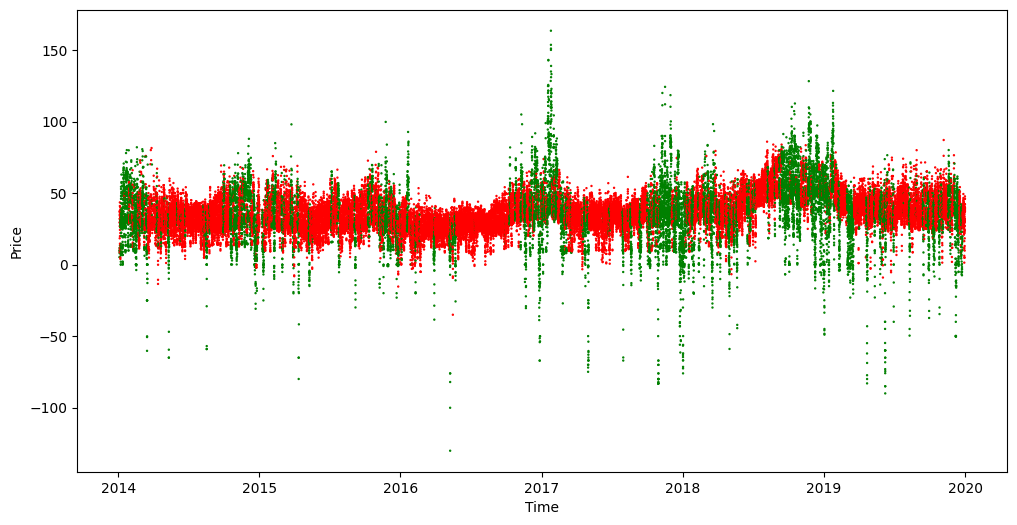

In [47]:
color_mapping = {0: 'r', 1: 'g'}

df['Color'] = df['Regime'].map(color_mapping)

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Price'], c=df['Color'], s=0.5)
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

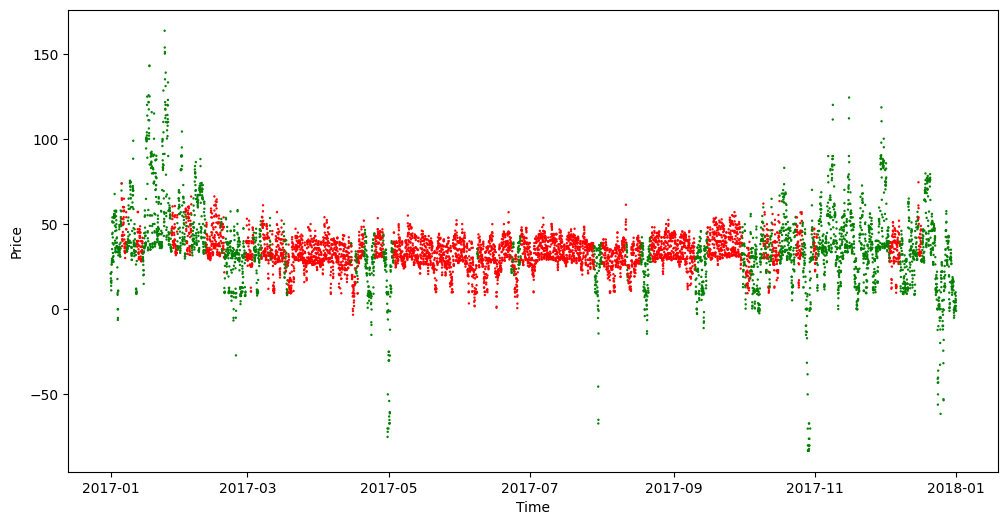

In [48]:
df_2017 = df[df.index.year == 2017]

plt.figure(figsize=(12, 6))
plt.scatter(df_2017.index, df_2017['Price'], c=df_2017['Color'], s=0.5)
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [49]:
df['Day'] = df.index.date
daily_df = pd.DataFrame(df.groupby('Day')['Regime'].value_counts(normalize=True).unstack())
daily_df.fillna(0, inplace=True)
daily_df.index = pd.to_datetime(daily_df.index)

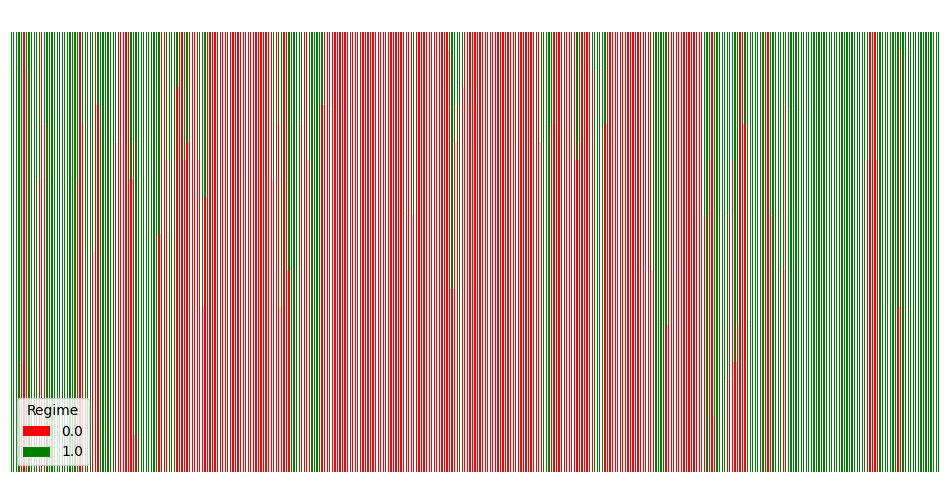

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))
daily_df[daily_df.index.year == 2017].plot(kind='bar', stacked=True, ax=ax, color=['r', 'g'])
ax.axis('off');

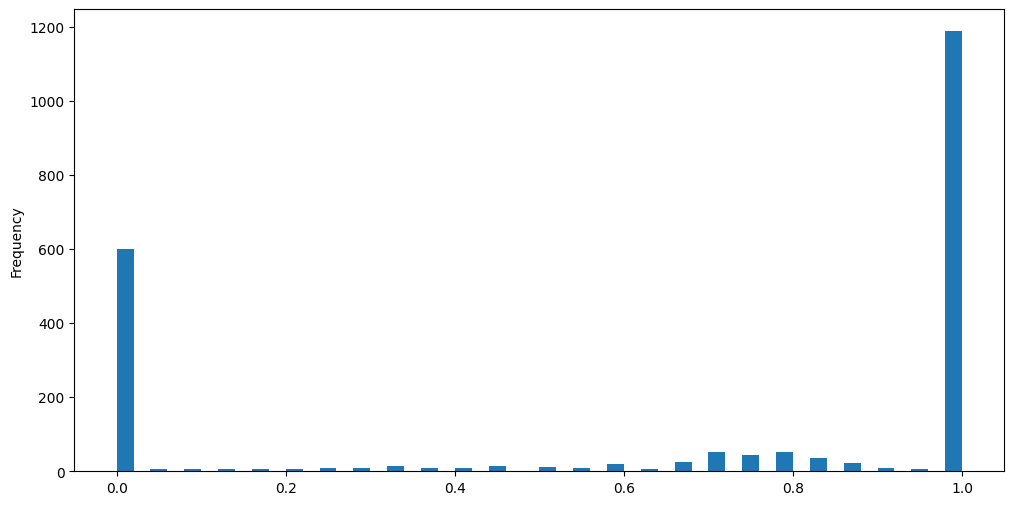

In [52]:
daily_df[0].plot(kind='hist', figsize=(12, 6), bins=50);

In [59]:
daily_df['Regime'] = (daily_df[0] > daily_df[1]).astype(int)
daily_df['Regime'].value_counts()

Regime
1    1472
0     709
Name: count, dtype: int64

In [79]:
daily_df = daily_df[['Regime']].join(df.groupby('Day')['Price'].apply(lambda df: df.reset_index(drop=True)).unstack())
daily_df.drop(24, axis=1, inplace=True)
daily_df.dropna(inplace=True)
daily_df

,Regime,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
Day,,,,,,,,,,,,,,,,,,,,,
2014-01-04,1,10.07,9.84,7.93,5.23,5.18,8.96,8.72,18.40,26.86,...,36.38,34.18,37.36,43.49,40.97,31.92,29.44,29.40,29.03,24.30
2014-01-05,1,19.92,14.69,13.33,10.96,11.56,11.66,11.00,11.38,13.77,...,28.41,28.06,33.16,34.94,40.13,38.49,34.67,29.40,28.81,22.08
2014-01-06,0,13.84,11.89,9.85,5.09,3.98,8.24,13.21,26.09,27.71,...,28.14,29.00,30.19,31.41,30.77,29.48,29.00,28.34,26.02,11.55
2014-01-07,0,9.26,7.59,0.07,0.07,2.05,6.52,26.07,31.17,32.91,...,35.81,43.00,46.00,54.44,52.92,47.99,34.99,28.59,28.14,20.06
2014-01-08,0,22.01,14.61,12.67,11.34,11.37,22.41,30.31,46.20,49.96,...,31.22,33.53,37.68,57.67,62.96,50.95,48.39,38.97,35.92,29.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,1,31.17,30.02,28.67,28.70,29.19,31.03,33.10,38.89,38.55,...,42.20,45.13,46.53,49.38,44.88,43.99,39.52,36.67,35.38,33.57
2019-12-28,1,30.17,29.50,29.43,28.20,28.53,27.40,29.20,31.63,34.61,...,34.91,35.86,39.86,40.79,43.75,43.29,39.62,35.39,34.75,30.17
2019-12-29,1,30.60,28.10,26.92,22.85,20.97,21.31,22.72,25.10,27.52,...,30.80,32.86,33.97,39.53,41.16,39.60,38.14,32.00,30.11,25.52
